# This notebook will showcase some of the functions in the module.

### Import modules
We use a somewhat dirty workaround to import the custom module without installing it - so far I have not set up installation of the module: repo_dir must be an absolute path to a dir containing a subdir "functions" in which FCSArtifactFixer.py is positioned. The sys module is then used to add that to the python path, and then we import.
You can create the path for repo_dir in any way you like, here I use the relative path in the repo.


In [1]:
# For I/O
import os
import sys

# For localizing FCSArtifactFixer
repo_dir = os.path.abspath('..')

# For data processing
sys.path.insert(0, repo_dir)
import tttrlib
from functions import FCSArtifactFixer
import numpy as np

# Other
import matplotlib.pyplot as plt # Plotting
import datetime # Time tagging
import warnings # Suppressing warnings in plotting

### Specify and import data
We again use the relative path within repo_dir, but of course you can specify anything you like.

In [2]:
in_dir = '../test_data/4ch_setup/'
in_file = 'membr_assoc_prot_A655.ptu'

# Define full input and output paths. 
# We add a time tag to the ouput path to avoid overwriting when experimenting with settings
in_path = os.path.join(in_dir, in_file)
out_path = os.path.join(in_dir, datetime.datetime.now().strftime("%Y%m%d_%H%M") +'_'+ os.path.splitext(in_file)[0])

# Import raw data as tttrlib.TTTR object
photon_data = tttrlib.TTTR(in_path,'PTU')

# Print something from TTTR object, just to confirm that we had a meaningful import
print(f'Imported {len(photon_data)} photons in routing channels {np.unique(photon_data.routing_channels)}.')

Imported 3814275 photons in routing channels [0 1 2 3 4 5].


### Create FCSArtifactFixer instance and define global settings

Parameters:

out_path: The output directory we had specified above

tau_min, tau_max: Minimum and maximum lag times for correlation in seconds. Can be overwritten at later steps.

sampling: Correlation function sampling density

cross_corr_symm: In cross-correlation, forward time and backward time correlation fucntions can be different in non-equilibrium systems. If you are confident that there will be no notable asymmetry, you can average forward and backward for better signal-to-noise ratio.

correlation_method: Which correlation algorithm implementation to use in the background. "default" or "lamb"

subtract_afterpulsing: Whether to use the calibration-based correction of afterpulsing. Requires a suitable calibration file, which is included in the repo for the 2-channel setup, but not for the 4-channel setup.

weights_ext: Advaned stuff that is not used in this example. This is a handle for importing custom external photon-wise weights for FLCS/fFCS.

write_results: Whether to automatically write .csv and .png output files (not every function will create files, but many). Recommended to leave True.

include_header: Whether the .csv output files are supposed to contain a header line or not. Generally True is recommended to get files that are much easier to understand, but we allowed False for better machine readability.

write_log: Independent of write_results, you can specifiy whether or not to write a logfile which documents most processing steps and the implicit decisions that the software makes in the background.

While this is not a setting for the FCSArtifactFixer instance, we also specify a name for the script itself, which we use later to indicate in the log file which functions have been called directly from the iPython Notebook.


In [3]:
# Settings

tau_min = 1E-6 
tau_max = 1.0 
sampling = 6 
cross_corr_symm = True 
correlation_method = 'default'
subtract_afterpulsing = False
afterpulsing_params_path = os.path.join(repo_dir, 'functions/ap_params_2ch_setup.csv')
     # relative path assuming it is in same dir as module

script_name = '01_overview.ipynb'

fixer = FCSArtifactFixer.FCSArtifactFixer(photon_data = photon_data, 
                                            out_path = os.path.abspath(out_path),
                                            tau_min = tau_min,
                                            tau_max = tau_max,
                                            sampling = sampling,
                                            cross_corr_symm = cross_corr_symm,
                                            correlation_method = correlation_method,
                                            subtract_afterpulsing = subtract_afterpulsing,
                                            afterpulsing_params_path = afterpulsing_params_path,
                                            weights_ext = None,
                                            write_results = True,
                                            include_header = True,
                                            write_log = True)
print(fixer.out_path)

/fs/gpfs41/lv02/fileset02/pool/pool-schwille-spt/_Software/FCS_cleaner_dev/FCSArtifactFixer/test_data/4ch_setup/20230921_1257_membr_assoc_prot_A655


### Hello World!
Very simple correlation function calculation, just to see that indeed the class instance can run a correlation with the settings specified above. Note that the method .simple_correlation() uses externally supplied macro_time tags. 

You can also use this cell to check out a few channel combinations in your data to figure out which ones look like they might be worth checking out.

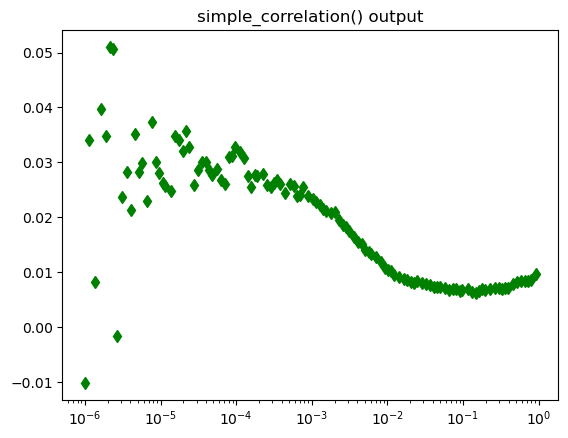

In [4]:
i_channel_1 = 1
i_channel_2 = 2

photon_inds1 = photon_data.get_selection_by_channel([i_channel_1])
photon_inds2 = photon_data.get_selection_by_channel([i_channel_2])
macro_times1 = photon_data.macro_times[photon_inds1]
macro_times2 = photon_data.macro_times[photon_inds2]
lags1, cc1 = fixer.simple_correlation(np.uint64(macro_times1),
                                      np.uint64(macro_times2))

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags1*1E-9, cc1-1, 'dg')
ax.set_title('simple_correlation() output')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### How to specify channels
FCSArtifactFixer uses a specific syntax to specify which channels to use in correlation. Or rather, it supports 3 different formats:
1. simple int for a single channel without micro time gating

2. tuple, list, or np.array (1D) of int for a sum channel without micro time gating

3. nested tuple for one or multiple channels with micro time gating. In this case, you need this structure:
       ((tuple_of_int_specifying_one_or_multiple_channels), 
           ((tuple_of_float_specifying_PIE_gate_edges), (tuple_of_int_specifying_which_gates_to_use)))

-------------------------

To explain the somewhat difficult format 3 in more detail, let's look at this example:

((1,2), ((0.5,), (1,)))

This example means:

Combine the photons in channels 1 and 2 (first inner tuple (1,2).

Split the micro time cycle into two 50/50 gates for Pulsed Interleaved Excitation (0.5 in the first innermost tuple in the second inner tuple). 

Use only the photons in the second half of the micro time cycle (index 1 in the second innermost tuple in the second inner tuple).

Note that, while hardly ever will anyone do this, you can specify as many micro time gate cutoffs, and combine photons from as many as you like.

--------------------------

The method .check_channels_spec() allows you to 1. check whether your input is correctly formatted, and 2. convert input from formats 1 and 2 to format 3, which is the default format used by the class in the background (the latter is not something you usually need to do as user - the software will handle that itself when needed).

In [5]:
#The three examples for channels_spec_1 are equivalent.
# Play around to confirm, and try modifying and see if .check_channels_spec() is happy with your input.

# channels_spec_1 = 0 # Format 1
# channels_spec_1 = (0,) # Format 2
# channels_spec_1 = ((0,), ((), (0,))) # FOrmat 3

channels_spec_1 = ((1,), ((0.5,), (1,)))
channels_spec_2 = ((2,), ((0.5,), (1,)))

print(f'Normalized channels_spec_1: {fixer.check_channels_spec(channels_spec_1)}')
print(f'Normalized channels_spec_2: {fixer.check_channels_spec(channels_spec_2)}')

Normalized channels_spec_1: ((1,), ((0.5,), (1,)))
Normalized channels_spec_2: ((2,), ((0.5,), (1,)))


### Same correlation operation (for now), but with a  different function
Now we calculate the same correlation function again, but using a different method: .correlation_apply_filters(). For now, it will create the same output, but .correlation_apply_filters() runs the correlation applying the insights from all the artifact correction calculations we are going to try out in the following cells.

Parameters of .correlation_apply_filters():
channels_spec_1, channels_spec_2: 
    Two channel configuration specifiers for the correlation operation. 
    See description in self.check_channels_spec() for details.
ext_indices :
    OPTIONAL np.array Externally specified indices of photons in the self.photon_data 
    tttr object to use in correlation. Can be used in slicing 
    data into a series of correlation fucntions, or to 
    randomize stuff (bootstrap), but of course this is also a handle 
    for the user to do their own custom photon selection on top of 
    built-in filters.
tau_min, tau_max:
    OPTIONAL specifier for minimum and maximum lag time to correlate. 
    float in ns. If empty or not specified at all, will be replaced by global defaults.
use_ext_weights :
    OPTIONAL bool. Whether to use the external weights stored in 
    self._weights_ext containing photon weights from FLCS 
    filter etc. If False (default), ones will be 
    imputed (no specific weighting).
use_drift_correction :
    OPTIONAL bool with default False. Whether to consider photon weights 
    from undrifting in photon weights.
use_flcs_bg_corr :
    OPTIONAL bool with default False. Whether to consider photon weights 
    from FLCS background correction in photon weights.
use_burst_removal :
    OPTIONAL bool. Specifies whether or not to use the attributes 
    self._macro_time_correction_burst_removal and self._weights_burst_removal to mask out 
    photons labelled as burst photons
use_mse_filter :
    OPTIONAL bool. Specifies whether or not to use the attributes 
    self._weights_anomalous_segments and self._macro_times_correction_mse_filter
    to mask out photons labelled as being in an anomalous time segment.
suppress_logging :
    OPTIONAL bool. If the function called with suppress_logging == True, the call will 
    not be registered in the log file even if the class instance has been 
    set to create a log file. The default is False.
calling_function : 
    string, optional This is a handle specifically meant for logging 
    which function had called this function. To make the code stack 
    more understandable in the log.


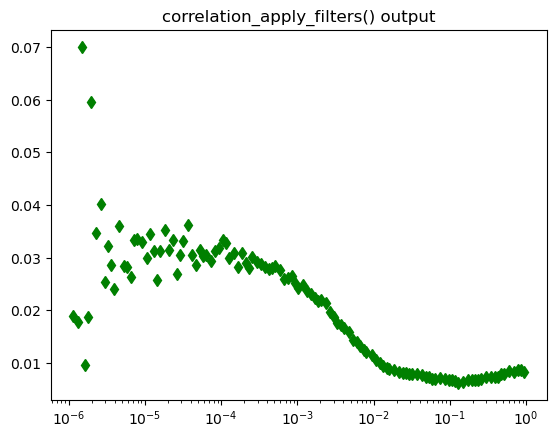

In [6]:
lags, cc, acr1, acr2 = fixer.correlation_apply_filters(channels_spec_1, 
                                                         channels_spec_2,
                                                         ext_indices = np.array([]),
                                                         tau_min = None, 
                                                         tau_max = None,
                                                         use_ext_weights = False, 
                                                         use_drift_correction = False, 
                                                         use_flcs_bg_corr = False,
                                                         use_burst_removal = False,
                                                         use_mse_filter = False,
                                                         suppress_logging = False,
                                                         calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags*1E-9, cc, 'dg')
ax.set_title('correlation_apply_filters() output')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Segmenting the acquisition
We can split the acquisition into multiple segments and get a set of correlation functions. The only new argument here is minimum_window_length, which specifies in seconds the minimal desired duration of segments. .get_segment_ccs wraps .correlation_get_uncertainty(), so it works with all filters.

Note that when calculating segment correlation functions, sometimes strange things can happen. There is a reason why you should not make FCS acquisitions too short...

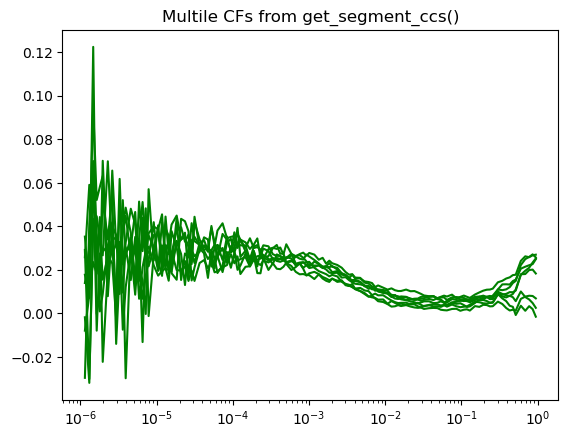

In [7]:
minimum_window_length = fixer.acquisition_time / 8.


lag_times, segment_ccs, usable_segments, start_stop = fixer.get_segment_ccs(channels_spec_1,
                                                                            channels_spec_2,
                                                                            minimum_window_length = minimum_window_length,
                                                                            tau_min = None,
                                                                            tau_max = None,
                                                                            use_ext_weights = False,
                                                                            use_drift_correction = False,
                                                                            use_flcs_bg_corr = False,
                                                                            use_burst_removal = False,
                                                                            use_mse_filter = False,
                                                                            suppress_logging = False,
                                                                            calling_function = script_name
                                                                            )

# PLot
fig, ax = plt.subplots(nrows=1, ncols=1)
[ax.semilogx(lags*1E-9, segment_ccs[:,i_segment], 'g') for i_segment in usable_segments]
ax.set_title('Multile CFs from get_segment_ccs()')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Uncertainty I: Variance of acquisition segments
FCSArtifactFixer supports two methods for calculating a correlation function uncertainty. The first, which is generally used as the default, is the method developed by Thorsten Wohland and co-workers (see Wohland, Vogel, Rigler Biophysical J 2001, DOI: 10.1016/S0006-3495(01)76264-9 (method 4 proposed in that paper). We use the very creative name "Wohland method" to refer to this method. In this method, the acquisition is cut into a sequence of short segments, each is correlated, and the uncertainty for the full-length correlation is calculated from the variance of this set of segment correlation functions.

The parameters for .get_Wohland_SD() are essentially the same as for .correlation_get_uncertainty(). What we add on top is minimum_window_length, which specifies minimum width for the time windows in which to separate the trace in seconds. minimum_window_length is optional and if not specified (default empty list), it is automatically chosen based on acquisition time and tau_max.

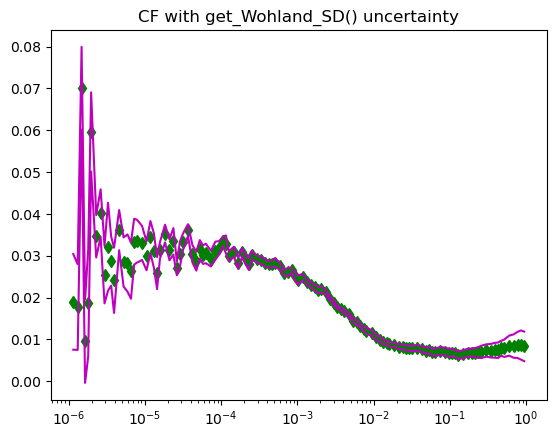

In [8]:
minimum_window_length = []


sd_cc_W = fixer.get_Wohland_SD(channels_spec_1,
                               channels_spec_2,
                               minimum_window_length = minimum_window_length,
                               tau_max = None,
                               tau_min = None,
                               use_ext_weights = False, 
                               use_drift_correction = False, 
                               use_flcs_bg_corr = False,
                               use_burst_removal = False,
                               use_mse_filter = False,
                               suppress_logging = False,
                               calling_function = script_name)

# PLot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags*1E-9, cc, 'dg')
ax.semilogx(lags*1E-9, cc+sd_cc_W, '-m')
ax.semilogx(lags*1E-9, cc-sd_cc_W, '-m')
ax.set_title('CF with get_Wohland_SD() uncertainty')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Uncertainty II: Bootstrap
The Wohland method requires sufficient measurement time. Is the total acquisition time is too short compared to tau_max, .get_Wohland_SD() will actually abort and instead implicitly call another method, which you can also explictly call if you prefer: .get_bootstrap_SD(). 

Bootstrap-resampling-based uncertainly standard deviation calculation for a correlation function. Normally, bootstrapping works best for unsorted data, and is not really a method for ordered time series data. It does work surprisingly well for FCS though if you bootstrap which photons to include in the correlation function, without changing anything about their order.

Bootstrapping yields slightly different uncertainty estimates than the Wohland method. In essence, bootstrapping only captures the uncertaintly from photon shot noise, not that from insufficient particle statistics. The advantages of bootstrapping are that, different from the Wohland method, it works with arbitrarily short measurements, and, different from other methods, it is free from any model assumptions about the underlying
physical processes.

Therefore, it is included here mostly for use as a backup method in case the data is too short for a meaningful Wohland method uncertainty calculation.

.get_bootstrap_SD() uses the same settings as .correlation_apply_filters(), with the addition of n_bootstrap_reps. n_bootstrap_reps specifies how many bootstrap replicates to perform, with default 10. Note that many bootstrap replicates get computationally expensive!

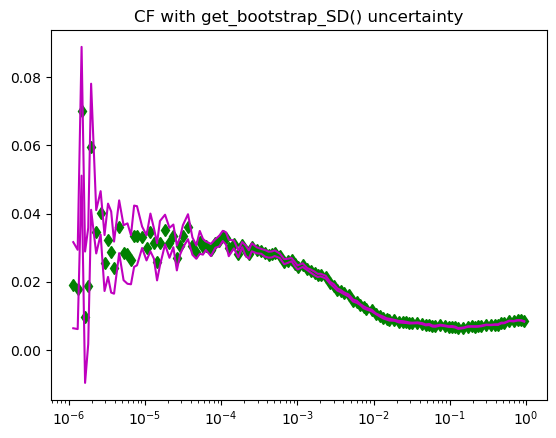

In [9]:
n_bootstrap_reps = 10

sd_cc_bs = fixer.get_bootstrap_SD(channels_spec_1,
                                    channels_spec_2, 
                                    n_bootstrap_reps = n_bootstrap_reps,
                                    tau_min = None,
                                    tau_max = None,
                                    use_ext_weights = False, 
                                    use_drift_correction = False,
                                    use_flcs_bg_corr = False,
                                    use_burst_removal = False,
                                    use_mse_filter = False,
                                    suppress_logging = False,
                                    calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags*1E-9, cc, 'dg')
ax.semilogx(lags*1E-9, cc+sd_cc_bs, '-m')
ax.semilogx(lags*1E-9, cc-sd_cc_bs, '-m')
ax.set_title('CF with get_bootstrap_SD() uncertainty')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### A shortcut, and fitting
.correlation_apply_filters() and .get_Wohland_SD() are both wrapped by .get_correlation_uncertainty(), meaning that you can shortcut the above cells! You already are familiar with the parameters, and default_uncertainty_method is the choice between 'Wohland' (with bootstrap as backup), or 'Bootstrap' only.

Also, in this cell we see that the FCSArtifactFixer module contains not only the FCSArtifactFixer class but also some other smaller classes. The first two we see here are classes meant for fitting of FCS correlation functions. The fit models are supplied with a few order-of-magnitude dummy values here. Most of the parameters should be pretty self-explaining though. Basically, you supply some metadata parameters, and some initial parameters for the fit. The count_rate and BG (background count rate) parameters in the fit are for correcting the correlation amplitude for background. 

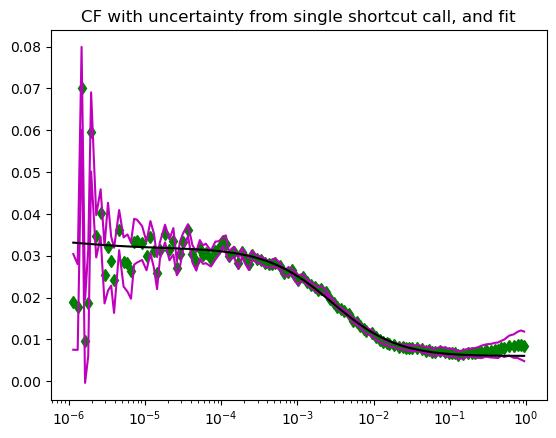

In [10]:
default_uncertainty_method = 'Wohland'
minimum_window_length = []
n_bootstrap_reps = 10

fit_two_components = True # Use one- or two-component model?
fit_2d_model = False # Strcitly speaking, currently no 2D model is implemented, but we can approximate it

lags, cc, sd_cc, acr1, acr2 = fixer.get_correlation_uncertainty(channels_spec_1,
                                                                channels_spec_2, 
                                                                default_uncertainty_method = default_uncertainty_method,
                                                                minimum_window_length = minimum_window_length,
                                                                n_bootstrap_reps = n_bootstrap_reps,
                                                                tau_min = None,
                                                                tau_max = None,
                                                                use_ext_weights = False, 
                                                                use_drift_correction = False,
                                                                use_flcs_bg_corr = False,
                                                                use_burst_removal = False,
                                                                use_mse_filter = False,
                                                                suppress_logging = False,
                                                                calling_function = script_name)

if fit_two_components:
    fcs_fit = FCSArtifactFixer.G_diff_3dim_2comp(tau = lags*1E-9, 
                                                 G = cc, 
                                                 sigma_G = sd_cc, 
                                                 count_rate = (acr1 + acr2) / 2, 
                                                 BG = 0., 
                                                 PSF_radius = 0.2,
                                                 PSF_aspect_ratio = 1E3 if fit_2d_model else 5., 
                                                 initial_params = {'N':1., 
                                                                   'tau diffusion 1':1E-4, 
                                                                   'tau diffusion 2':1E-2, 
                                                                   'f1': 0.5,
                                                                   'offset':0.})
else: 
    fcs_fit = FCSArtifactFixer.G_diff_3dim_1comp(tau = lags*1E-9, 
                                                 G = cc, 
                                                 sigma_G = sd_cc, 
                                                 count_rate = (acr1 + acr2) / 2, 
                                                 BG = 0., 
                                                 PSF_radius = 0.2, 
                                                 PSF_aspect_ratio = 1E3 if fit_2d_model else 5., 
                                                 initial_params = {'N':1., 'tau diffusion':1E-3, 'offset':0.})

fit_results = fcs_fit.run_fit()

# PLot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags*1E-9, cc, 'dg')
ax.semilogx(lags*1E-9, cc+sd_cc, '-m')
ax.semilogx(lags*1E-9, cc-sd_cc, '-m')
ax.semilogx(lags*1E-9, fit_results['G_prediction'], 'k')

ax.set_title('CF with uncertainty from single shortcut call, and fit')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Constructing a fluorescence time trace
We will in various following steps work with time traces, so let's look at how to get one. .get_time_trace() is pretty strightforward. It is far from being the most computationally efficient implementation, but it is chosen to be compatible with all filters. The crucial new parameter is time_trace_sampling, which is the time bin width of the time trace in seconds.

We can specify time_trace_sampling, or we can let the software chose by itself based on the data. The latter is done though .get_time_trace_scale(), which looks at two or three criteria depending on settings. The idea is that the bin width should:
1. Contain enough photons on average (min_avg_counts)
2. Not be stupidly short to avoid inflating the number of data points 
    (min_bin_width). This also serves as a safety net in case the diffusion
    time (3.) is misestimated.
3. If desired, not be shorter than the shortest observed diffusion 
    time (approx. average residence time of molecules in observation 
    volume), which again would be useless oversampling

The function looks at the three criteria and choses the shortest bin width to fulfil all.

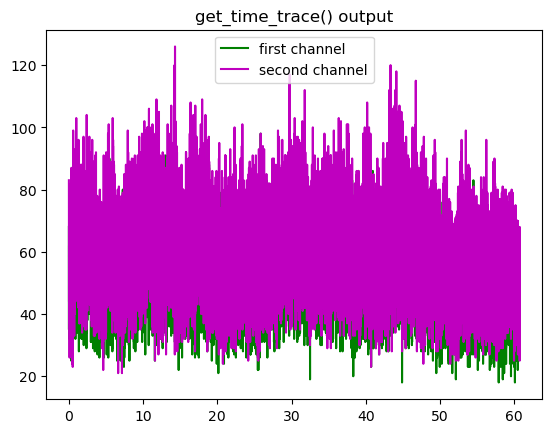

In [11]:
min_avg_counts = 10.
min_bin_width = 1E-4
use_tau_diff = True

time_trace_sampling = fixer.get_trace_time_scale(channels_spec_1,
                                                 min_avg_counts = min_avg_counts,
                                                 min_bin_width = min_bin_width,
                                                 use_tau_diff = use_tau_diff,
                                                 ext_indices = np.array([]),
                                                 use_ext_weights = False,
                                                 use_drift_correction = False,
                                                 use_flcs_bg_corr = False,
                                                 use_burst_removal = False,
                                                 use_mse_filter = False,
                                                 suppress_logging = False,
                                                 calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    # If we have two-channel data, let's use a geometric mean of 
    # time_trace_sampling suggestions for two the two channels as compromise
    time_trace_sampling = np.sqrt(time_trace_sampling * fixer.get_trace_time_scale(channels_spec_2,
                                                                                   min_avg_counts = min_avg_counts,
                                                                                   min_bin_width = min_bin_width,
                                                                                   use_tau_diff = use_tau_diff,
                                                                                   ext_indices = np.array([]),
                                                                                   use_ext_weights = False,
                                                                                   use_drift_correction = False,
                                                                                   use_flcs_bg_corr = False,
                                                                                   use_burst_removal = False,
                                                                                   use_mse_filter = False,
                                                                                   suppress_logging = False,
                                                                                   calling_function = script_name))

time_trace_counts_1, time_trace_t_1 = fixer.get_time_trace(channels_spec_1,
                                                           time_trace_sampling,
                                                           ext_indices = np.array([]),
                                                           use_ext_weights = False,
                                                           use_drift_correction = False,
                                                           use_flcs_bg_corr = False,
                                                           use_burst_removal = False,
                                                           use_mse_filter = False,
                                                           suppress_logging = False,
                                                           calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    time_trace_counts_2, time_trace_t_2 = fixer.get_time_trace(channels_spec_2,
                                                               time_trace_sampling,
                                                               ext_indices = np.array([]),
                                                               use_ext_weights = False,
                                                               use_drift_correction = False,
                                                               use_flcs_bg_corr = False,
                                                               use_burst_removal = False,
                                                               use_mse_filter = False,
                                                               suppress_logging = False,
                                                               calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(time_trace_t_1, time_trace_counts_1, 'g', label = 'first channel')

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    ax.plot(time_trace_t_2, time_trace_counts_2, 'm', label = 'second channel')
    ax.legend()
    
ax.set_title('get_time_trace() output')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Artifact fix 1: Burst removal
Let's get started with the automated artifact removal methods that are the main point of the module. The first one is the removal of bright signal bursts, which can easily distort the correlation function. We use a custom procedure different from the tttrlib built-in, again to facilitate combination of the different filters in the module. This is technically a four-step procedure:
1. Get time trace(s) in which to detect bursts (we did that in the previous cell)
2. Decide for a threshold of photon counts per bin (this cell)
3. Apply threshold, gettting an annotation of which time windows are "burst" and which are "non-burst" (this cell)
4. Annotate on a photon-by-photon basis which (non-burst) photons to keep (two cells later)

Step 3 is done by the rather simple function .threshold_trace(), which uses as input a time trace and threshold photon count value. 

Step 2 is the more interesting one. The user can of course choose a threshold of their linking by inspecting the time trace. But we also can use .get_auto_threshold(), which uses outlier-robust quantile statistics to parametrize an approximate photon counting histogram (as a simple Gaussian approximation of only the right side of the distribution), and from that model chooses a threshold based on a user-supplied false-positive thresholding probability threshold_alpha (in the sense of a Sidak-corrected one-sided t-test for outlier detection). This will often lead to a bit of over-thresholding, but not too bad, depending on the chosen threshold_alpha.

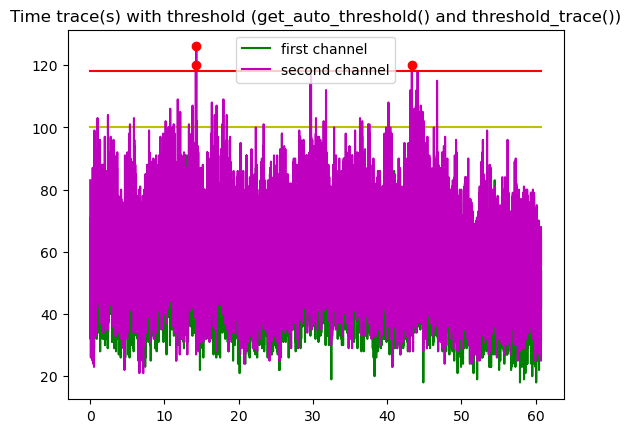

In [12]:
threshold_alpha = 0.05

auto_threshold_1 = fixer.get_auto_threshold(time_trace_counts_1,
                                            threshold_alpha = threshold_alpha,
                                            suppress_logging = False,
                                            calling_function = script_name)

binarized_trace_1 = fixer.threshold_trace(time_trace_counts_1, 
                                          threshold_counts = auto_threshold_1,
                                          suppress_logging = False,
                                          calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):

    auto_threshold_2 = fixer.get_auto_threshold(time_trace_counts_2,
                                                threshold_alpha = threshold_alpha,
                                                suppress_logging = False,
                                                calling_function = script_name)
    
    binarized_trace_2 = fixer.threshold_trace(time_trace_counts_2, 
                                              threshold_counts = auto_threshold_2,
                                              suppress_logging = False,
                                              calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(time_trace_t_1, time_trace_counts_1, 'g', label = 'first channel')
ax.plot([time_trace_t_1[0], time_trace_t_1[-1]], [auto_threshold_1, auto_threshold_1], '-y')
ax.plot(time_trace_t_1[binarized_trace_1], time_trace_counts_1[binarized_trace_1], 'oy')

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    ax.plot(time_trace_t_2, time_trace_counts_2, 'm', label = 'second channel')
    ax.plot([time_trace_t_2[0], time_trace_t_2[-1]], [auto_threshold_2, auto_threshold_2], '-r')
    ax.plot(time_trace_t_2[binarized_trace_2], time_trace_counts_2[binarized_trace_2], 'or')
    ax.legend()
    
ax.set_title('Time trace(s) with threshold (get_auto_threshold() and threshold_trace())')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Shortcut for burst detection
What has been described in the previous cell as steps 2 and 3 of burst removal can actually be shortcut by a single function. One that you already know: .threshold_trace() can also be used without specifying threshold_counts,  instead using the argument threshold_alpha, in which case .threshold_trace() calls .get_auto_threshold() (if you specify neither threshold_counts nor threshold_alpha, it will proceed with threshold_alpha = 0.02).

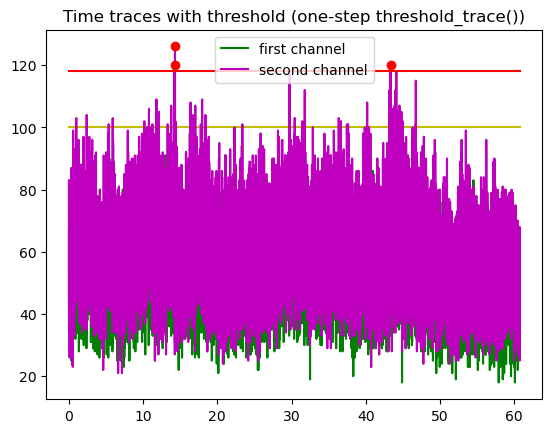

In [13]:
threshold_alpha = 0.05


binarized_trace_1 = fixer.threshold_trace(time_trace_counts_1, 
                                          threshold_alpha = threshold_alpha,
                                          suppress_logging = False,
                                          calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    binarized_trace_2 = fixer.threshold_trace(time_trace_counts_2, 
                                              threshold_alpha = threshold_alpha,
                                              suppress_logging = False,
                                              calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(time_trace_t_1, time_trace_counts_1, 'g', label = 'first channel')
ax.plot([time_trace_t_1[0], time_trace_t_1[-1]], [auto_threshold_1, auto_threshold_1], '-y')
ax.plot(time_trace_t_1[binarized_trace_1], time_trace_counts_1[binarized_trace_1], 'oy')

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    ax.plot(time_trace_t_2, time_trace_counts_2, 'm', label = 'second channel')
    ax.plot([time_trace_t_2[0], time_trace_t_2[-1]], [auto_threshold_2, auto_threshold_2], '-r')
    ax.plot(time_trace_t_2[binarized_trace_2], time_trace_counts_2[binarized_trace_2], 'or')
    ax.legend()
    
ax.set_title('Time traces with threshold (one-step threshold_trace())')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Annotating photons as burst and non-burst
This is step 4 in the text two cells above. Here we use the binarized trace, and the information about the time resolution with which the trace was calculated, to go back to the photons themselves and annotate them. We then look what that did to time trace and correlation function.

Why is this seemingly trivial step a separate step? If we run burst detection on more than one time trace (e.g., the distinct channels in cross-correlation), we can think of various ways to do burst removal on them:

1. We can run the burst detection on the sum of the channels.
2. We can restrict burst removal to discarding time points that are burst in both/all channels (logical AND). 
3. We can remove any time point that was burst in any channel (logical OR).

Also, when excising the bursts, we can either correct the time tags to completely excise that measurement time, or we can simply set the photon counts in the burst time windows to 0. This is controlled by the argument update_macro_times (True: shift time to collapse gaps left by burst removal) in .update_photons_from_bursts().

You can even use channels for burst detection that are not even included in the correlation function calculation, or create a binarized trace from some totally different custom calculations.

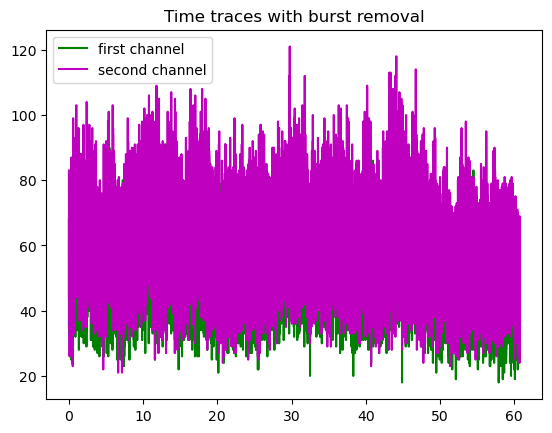

In [14]:
multi_channel_handling = 'OR' # If we have two distinct channels, do we do logical OR or logical AND (sum is not supported here)
update_macro_times = True



if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    if multi_channel_handling == 'OR':
        burst_bins = np.logical_or(binarized_trace_1, binarized_trace_2) 
    elif multi_channel_handling == 'AND':
        burst_bins = np.logical_and(binarized_trace_1, binarized_trace_2) 
    else:
        raise Error("Can't use that input for multi_channel_handling.")
else:
    burst_bins = binarized_trace_1
    
# Remove bursts from both channels
photon_is_burst = fixer.update_photons_from_bursts(burst_bins,
                                                   time_trace_sampling,
                                                   update_weights = True,
                                                   update_macro_times = update_macro_times,
                                                   suppress_logging = False,
                                                   calling_function = script_name)


# Re-calculate time trace(s) with burst removal
time_trace_counts_br_1, time_trace_t_br_1 = fixer.get_time_trace(channels_spec_1,
                                                                 time_trace_sampling,
                                                                 ext_indices = np.array([]),
                                                                 use_ext_weights = False,
                                                                 use_drift_correction = False,
                                                                 use_flcs_bg_corr = False,
                                                                 use_burst_removal = True,
                                                                 use_mse_filter = False,
                                                                 suppress_logging = False,
                                                                 calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    time_trace_counts_br_2, time_trace_t_br_2 = fixer.get_time_trace(channels_spec_2,
                                                                     time_trace_sampling,
                                                                     ext_indices = np.array([]),
                                                                     use_ext_weights = False,
                                                                     use_drift_correction = False,
                                                                     use_flcs_bg_corr = False,
                                                                     use_burst_removal = True,
                                                                     use_mse_filter = False,
                                                                     suppress_logging = False,
                                                                     calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(time_trace_t_br_1, time_trace_counts_br_1, 'g', label = 'first channel')

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    ax.plot(time_trace_t_br_2, time_trace_counts_br_2, 'm', label = 'second channel')
    ax.legend()
    
ax.set_title('Time traces with burst removal')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Short for entire burst removal procedure
We already saw a shortcut for steps 2 and 3 of the burst removal, now we get another shortcut for steps 2, 3, and 4, inlcuding multi-channel handling for 'logical OR', 'logical AND' and 'SUM'. Also, here we look at the updated correlation function.

The one thing we need to do here in addition is to concatenate multiple traces into a single 2D numpy array.

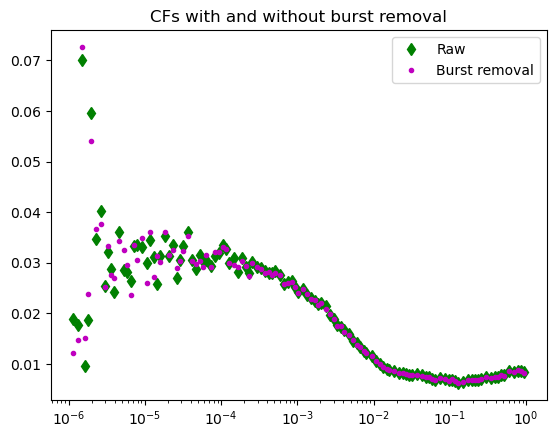

In [15]:
multi_channel_handling = 'OR' # 'OR', 'AND', or 'SUM'
threshold_alpha = 0.05
update_macro_times = True

default_uncertainty_method = 'Wohland'
minimum_window_length = []
n_bootstrap_reps = 10


if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    time_traces = np.concatenate((time_trace_counts_1.reshape((time_trace_counts_1.shape[0], 1)), time_trace_counts_2.reshape((time_trace_counts_2.shape[0], 1))), axis = 1) 
else:
    # The reshape is not really needed, we rather do it here for consistency of format. 
    time_traces = time_trace_counts_1.reshape((time_trace_counts_1.shape[0], 1))

burst_bins, photon_is_burst = fixer.run_burst_removal(time_traces,
                                                      time_trace_sampling,
                                                      multi_channel_handling = multi_channel_handling,
                                                      threshold_alpha = threshold_alpha,
                                                      threshold_counts = None,
                                                      update_weights = update_macro_times,
                                                      update_macro_times = True,
                                                      suppress_logging = False,
                                                      calling_function = script_name)

lags_br, cc_br, sd_cc_br, acr1_br, acr2_br = fixer.get_correlation_uncertainty(channels_spec_1,
                                                                               channels_spec_2, 
                                                                               default_uncertainty_method = default_uncertainty_method,
                                                                               minimum_window_length = minimum_window_length,
                                                                               n_bootstrap_reps = n_bootstrap_reps,
                                                                               tau_min = None,
                                                                               tau_max = None,
                                                                               use_ext_weights = False, 
                                                                               use_drift_correction = False,
                                                                               use_flcs_bg_corr = False,
                                                                               use_burst_removal = True,
                                                                               use_mse_filter = False,
                                                                               suppress_logging = False,
                                                                               calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags*1E-9, cc, 'dg', label = 'Raw')
ax.semilogx(lags_br*1E-9, cc_br, '.m', label = 'Burst removal')
ax.set_title('CFs with and without burst removal')
ax.legend()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Artifact fix 2: Bleaching/drift
The second artifact we correct is bleaching/drift. This again uses the tie trace as the basis for correction, and in this case attempts to find slow trends to correct. A polynomial fit is used to describe the coarse trend in the data, and then this drift is corrected based on eq. 4 in Ries, Chiantia and Schwille Biophys J 2009, DOI 10.1016/j.bpj.2008.12.3888. 

The order of the polynomial fit can be explicitly specified by the user, or optimized automatically. If automatic order tuning is chosen, the software starts with a zero-order polynomial (= no correction at all) and increments the order, inspecting statistical goodness-of-fit improvements. The order is considered optimized if two further increments in the order did not significantly change the goodness of fit. (Two increments rather than only one as the software alternates between even and odd orders, which may behave differently.)

This is a one-step procedure, no meaningful calculation intermediates to inspect. Note that we use the burst corrected trace as starting point.

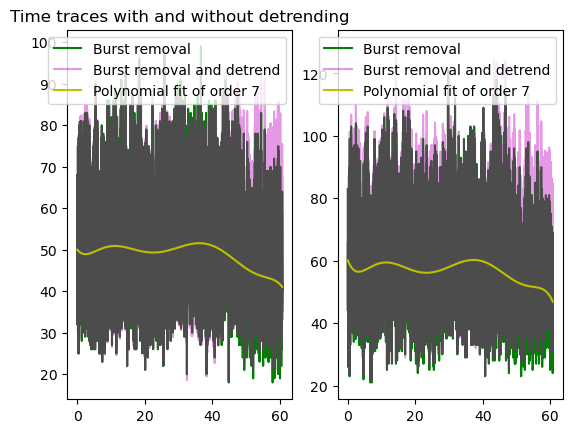

In [16]:
poly_params_1 , time_trace_poly_1, time_trace_undrift_1 = fixer.polynomial_undrifting_rss(time_trace_counts_br_1, 
                                                                                          time_trace_t_br_1, 
                                                                                          channels_spec_1,
                                                                                          undrift_order = None,
                                                                                          max_undrift_order = 10,
                                                                                          update_undrift_weights = True,
                                                                                          ext_indices = np.array([]),
                                                                                          use_ext_weights = False,
                                                                                          use_flcs_bg_corr = False,
                                                                                          use_burst_removal = False,
                                                                                          use_mse_filter = False,
                                                                                          suppress_logging = False,
                                                                                          calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    poly_params_2 , time_trace_poly_2, time_trace_undrift_2 = fixer.polynomial_undrifting_rss(time_trace_counts_br_2, 
                                                                                              time_trace_t_br_2, 
                                                                                              channels_spec_2,
                                                                                              undrift_order = None,
                                                                                              max_undrift_order = 10,
                                                                                              update_undrift_weights = True,
                                                                                              ext_indices = np.array([]),
                                                                                              use_ext_weights = False,
                                                                                              use_flcs_bg_corr = False,
                                                                                              use_burst_removal = False,
                                                                                              use_mse_filter = False,
                                                                                              suppress_logging = False,
                                                                                              calling_function = script_name)

    # Plot pre and post correction time traces
    
    # Still in the statement for two distinct channels
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].plot(time_trace_t_br_1*1E-9, time_trace_counts_br_1, 'g', label = 'Burst removal')
    ax[0].plot(time_trace_t_br_1*1E-9, time_trace_undrift_1, 'm', alpha = 0.4, label = 'Burst removal and detrend')
    ax[0].plot(time_trace_t_br_1*1E-9, time_trace_poly_1, 'y', label = 'Polynomial fit of order '+ str(len(poly_params_1)-1))
    ax[1].plot(time_trace_t_br_2*1E-9, time_trace_counts_br_2, 'g', label = 'Burst removal')
    ax[1].plot(time_trace_t_br_2*1E-9, time_trace_undrift_2, 'm', alpha = 0.4, label = 'Burst removal and detrend')
    ax[1].plot(time_trace_t_br_2*1E-9, time_trace_poly_2, 'y', label = 'Polynomial fit of order '+ str(len(poly_params_2)-1))
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title('Time traces with and without detrending')
    
else:
    # Plotting for single channel
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(time_trace_t_br_1*1E-9, time_trace_counts_br_1, 'g', label = 'Burst removal')
    ax.plot(time_trace_t_br_1*1E-9, time_trace_undrift_1, 'm', alpha = 0.4, label = 'Burst removal and detrend')
    ax.plot(time_trace_t_br_1*1E-9, time_trace_poly_1, 'y', label = 'Polynomial fit of order '+ str(len(poly_params_1)-1))
    ax.legend()
    ax.set_title('Time traces with and without detrending')

    
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

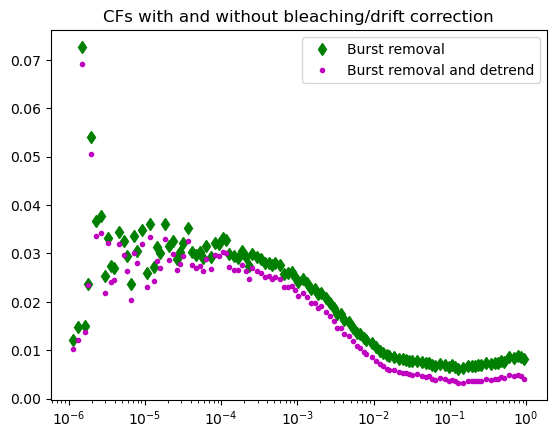

In [17]:
# Continuing from before: Inspect effect of drift correction on correlation function

default_uncertainty_method = 'Wohland'
minimum_window_length = []
n_bootstrap_reps = 10

lags_br_dt, cc_br_dt, sd_cc_br_dt, acr1_br_dt, acr2_br_dt = fixer.get_correlation_uncertainty(channels_spec_1,
                                                                                              channels_spec_2, 
                                                                                              default_uncertainty_method = default_uncertainty_method,
                                                                                              minimum_window_length = minimum_window_length,
                                                                                              n_bootstrap_reps = n_bootstrap_reps,
                                                                                              tau_min = None,
                                                                                              tau_max = None,
                                                                                              use_ext_weights = False, 
                                                                                              use_drift_correction = True,
                                                                                              use_flcs_bg_corr = False,
                                                                                              use_burst_removal = True,
                                                                                              use_mse_filter = False,
                                                                                              suppress_logging = False,
                                                                                              calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags_br*1E-9, cc_br, 'dg', label = 'Burst removal')
ax.semilogx(lags_br_dt*1E-9, cc_br_dt, '.m', label = 'Burst removal and detrend')
ax.set_title('CFs with and without bleaching/drift correction')
ax.legend()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Artifact fix 3: Remove segments with anomalous correlation functions
Next, we go back to inspecting correlation function segments as we did previously for uncertainty estiamtion, but this time to systematically look which segments look "weird". This is based on the pipeline described in Ries, ..., Schwille Optics Express 2010, DOI: 10.1364/OE.18.011073. Specifically, we compare each segment correlation function to the average of all others, calculating the mean-square-error. We then identify the worst-matching curve, and discard it from the set. Then, we repeat that cycle of comparison and removal with the remaining curves, until we have too few left to continue. That way, we get both an order and a quatitative parameter for the segment curves from "good" to "bad", and we use that with a user-defined cutoff for the fold change of MSE over minimum found MSE, and discard all segments beyond that cutoff.

The key parameters for the user to tune are minimum_window_length which works as above, mse_fold_threshold which is the fold-change cutoff, and ignore_amplitude_fluctuations. If you set ignore_amplitude_fluctuations to True (default), at each MSE calculation the "isolated" correlation function to compare to the others is linearly scaled to minimize the MSE. The idea is that doing reduces the effect of correlation amplitude fluctations on the MSE and emphasizes the correlation function shape stronger.

We use the result of burst removal + undrifting as input. Similar to the burst removal, you can choose whether to leave to close gaps via update_macro_times.

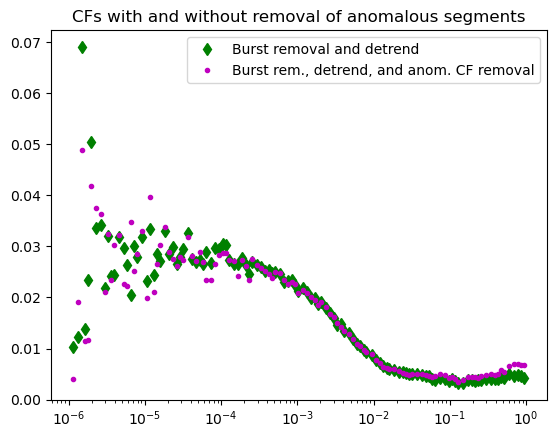

In [18]:
minimum_window_length = []
mse_fold_threshold = 2.5
update_macro_times = True
update_macro_times = True

mse_matrix, good_segments = fixer.run_mse_filter(channels_spec_1,
                                                 channels_spec_2,
                                                 minimum_window_length = minimum_window_length,
                                                 mse_fold_threshold = mse_fold_threshold,
                                                 ignore_amplitude_fluctuations = update_macro_times,
                                                 update_macro_times = update_macro_times,
                                                 update_weights = True,
                                                 tau_max = None,
                                                 tau_min = 1E5, # 100 us to cut off excessive noise
                                                 use_ext_weights = False, 
                                                 use_drift_correction = True, 
                                                 use_flcs_bg_corr = False,
                                                 use_burst_removal = True,
                                                 suppress_logging = False,
                                                 calling_function= script_name)

# Look at what that did to the correlation function
default_uncertainty_method = 'Wohland'
n_bootstrap_reps = 10

lags_br_dt_ar, cc_br_dt_ar, sd_cc_br_dt_ar, acr1_br_dt_ar, acr2_br_dt_ar = fixer.get_correlation_uncertainty(channels_spec_1,
                                                                                                             channels_spec_2, 
                                                                                                             default_uncertainty_method = default_uncertainty_method,
                                                                                                             minimum_window_length = minimum_window_length,
                                                                                                             n_bootstrap_reps = n_bootstrap_reps,
                                                                                                             tau_min = None,
                                                                                                             tau_max = None,
                                                                                                             use_ext_weights = False, 
                                                                                                             use_drift_correction = True,
                                                                                                             use_flcs_bg_corr = False,
                                                                                                             use_burst_removal = True,
                                                                                                             use_mse_filter = True,
                                                                                                             suppress_logging = False,
                                                                                                             calling_function = script_name)
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags_br_dt*1E-9, cc_br_dt, 'dg', label = 'Burst removal and detrend')
ax.semilogx(lags_br_dt_ar*1E-9, cc_br_dt_ar, '.m', label = 'Burst rem., detrend, and anom. CF removal')
ax.set_title('CFs with and without removal of anomalous segments')
ax.legend()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()
    

### Moving into the micro time regime
So far we have been looking only at macro times in correlation functions and time traces (and possibly implicitly included micro time information in the correlation function, if the queried time scales were so short that this became relevant). Before we move to artifact fix #4 (FLCS to correct background), we take a look at what the micro time representation of our photons actually is.

As you will see below, the filters for which that makes sense are also accessed by .get_tcspc_histogram().

Of note, .get_tcspc_histogram() also has a keyword argument micro_times which is left out here. micro_times can be used to get a micro time histogram not from the data in the TTTR object, but some other matching data. It is not an argument the is frequently used, but it was added as a convenience function for bringing together instrument response function data and measurement data.

Text(0.5, 1.0, 'Micro time histogram')

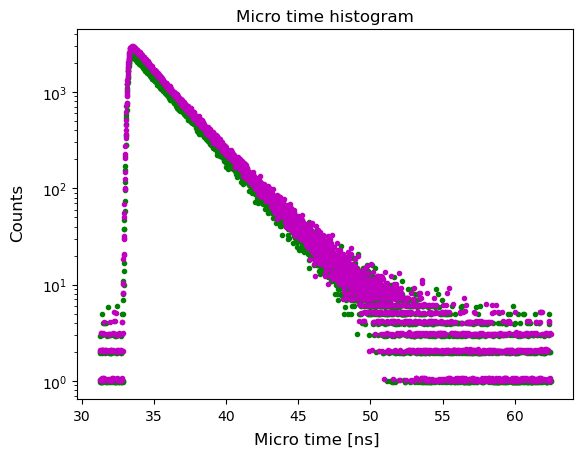

In [19]:
tcspc_x_1, tcspc_y_1 = fixer.get_tcspc_histogram(channels_spec_1,
                                                 ext_indices = np.array([]),
                                                 use_ext_weights = False,
                                                 use_drift_correction = True,
                                                 use_burst_removal = True,
                                                 use_mse_filter = True,
                                                 suppress_logging = False,
                                                 calling_function = script_name)

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    tcspc_x_2, tcspc_y_2 = fixer.get_tcspc_histogram(channels_spec_2,
                                                     ext_indices = np.array([]),
                                                     use_ext_weights = False,
                                                     use_drift_correction = True,
                                                     use_burst_removal = True,
                                                     use_mse_filter = True,
                                                     suppress_logging = False,
                                                     calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogy(tcspc_x_1 * fixer.micro_time_resolution * 1E9, 
            tcspc_y_1, '.g')

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    ax.semilogy(tcspc_x_2 * fixer.micro_time_resolution * 1E9, 
                tcspc_y_2, '.m')
    
fig.supxlabel('Micro time [ns]')
fig.supylabel('Counts')
ax.set_title('Micro time histogram')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()
    

### Artifact fix 4: Background (and afterpulsing) correction via FLCS
We will now use that micro time histogram to estimate the level of laser-independent background. Here, we use in the background another smaller class in the FCSArtifactFixer module, TCSPC quick fit, which is made to allow simple fitting of TCSPC data, either Gaussian fitting in an attempt of approximate IRF parameterization, or what we use here, exponential tail fitting.

The method .get_background_tail_fit() that we use in this first step relies on knowledge of the IRF peak position. You can use TCSPC_quick_fit on IRF data for that...Or you just find the maximum of the micro time histogram. Good enough. Also, you need to specify in micro time bin indices the left edge at which to start the tail fit. Closely inspect the example of how irf_peak_center and fit_start are defined: In TCSPC bins relative to the 0 of the TCSPC cycle. Not in seconds, not in nanoseconds, and not relative to the start of the PIE window. There are arguments for and against this, I settled for this structure.

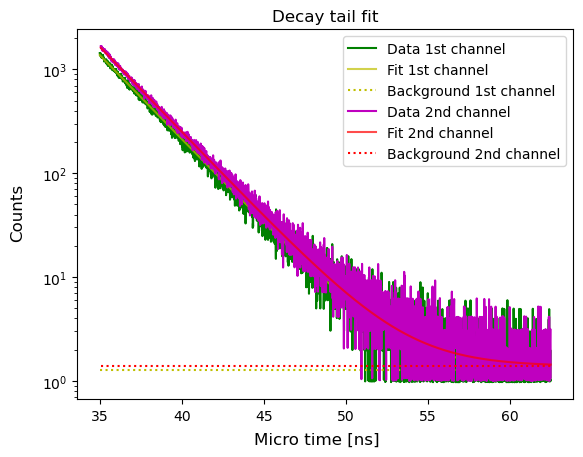

In [20]:
peak_position = np.argmax(tcspc_y_1) + tcspc_x_1[0]
fit_start = np.uint64(peak_position + np.ceil(2E-9 / fixer.micro_time_resolution)) # 1E-9 refers to 2 ns distance from peak here

flat_background_1, tail_fit_1 = fixer.get_background_tail_fit(channels_spec_1,
                                                                irf_peak_center = peak_position,
                                                                fit_start = fit_start,
                                                                ext_indices = np.array([]),
                                                                use_ext_weights = False,
                                                                use_drift_correction = True,
                                                                use_burst_removal = True,
                                                                use_mse_filter = True,
                                                                suppress_logging = False,
                                                                calling_function = script_name)
# The output variable tail_fit_1 is a TCSPC_quick_fit class instance, which you can inspect further if you like.

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogy(tail_fit_1.x * fixer.micro_time_resolution * 1E9,
            tail_fit_1.y, 'g', label='Data 1st channel')
ax.semilogy(tail_fit_1.x * fixer.micro_time_resolution * 1E9,
            tail_fit_1.prediction, 'y', alpha = 0.7, label='Fit 1st channel')
ax.semilogy(np.array([tail_fit_1.x[0], tail_fit_1.x[-1]]) * fixer.micro_time_resolution * 1E9,
            [flat_background_1, flat_background_1], ':y', label='Background 1st channel')

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    peak_position = np.argmax(tcspc_y_2) + tcspc_x_1[0]
    fit_start = np.uint64(peak_position + np.ceil(2E-9 / fixer.micro_time_resolution)) # 1E-9 refers to 2 ns distance from peak here

    flat_background_2, tail_fit_2 = fixer.get_background_tail_fit(channels_spec_2,
                                                                    irf_peak_center = peak_position,
                                                                    fit_start = fit_start,
                                                                    ext_indices = np.array([]),
                                                                    use_ext_weights = False,
                                                                    use_drift_correction = True,
                                                                    use_burst_removal = True,
                                                                    use_mse_filter = True,
                                                                    suppress_logging = False,
                                                                    calling_function = script_name)

    ax.semilogy(tail_fit_2.x * fixer.micro_time_resolution * 1E9,
                tail_fit_2.y, 'm', label='Data 2nd channel')
    ax.semilogy(tail_fit_2.x * fixer.micro_time_resolution * 1E9,
                tail_fit_2.prediction, 'r', alpha = 0.7, label='Fit 2nd channel')
    ax.semilogy(np.array([tail_fit_2.x[0], tail_fit_2.x[-1]]) * fixer.micro_time_resolution * 1E9,
                [flat_background_2, flat_background_2], ':r', label='Background 2nd channel')

    ax.legend()

fig.supxlabel('Micro time [ns]')
fig.supylabel('Counts')
ax.set_title('Decay tail fit')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Continuing FLCS correction: Get filter functions
Now we use the determined background level to calculate the FLCS weights. This is just some math, at this point there is nothing significant to set. 

The only setting you can really tinker with in principle is handle_outside, but honestly, I would advice against that: Its existence is honestly more of a historical accident and it's hard to come up with situations where you'd want to touch it. Basically, handle_outside asks "what do I do with photons that are not covered by the FLCS filter - do I leave their weight as-is, or do I set them to 0?" (Filter calculation range = range specified in channels_spec, NOT range used in tail fitting.) There is little reason to not set them to zero.

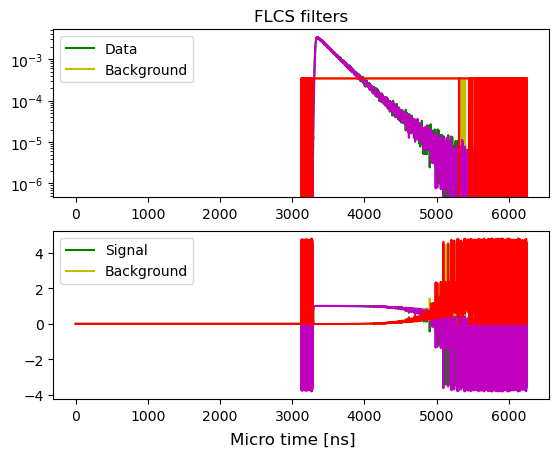

In [21]:
patterns_norm_full_1, flcs_weights_full_1 = fixer.get_flcs_background_filter(tcspc_x_1,
                                                                             tcspc_y_1,
                                                                             flat_background_1,
                                                                             channels_spec_1,
                                                                             handle_outside = 'zero',
                                                                             update_weights = True,
                                                                             ext_indices = np.array([]),
                                                                             suppress_logging = False,
                                                                             calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].semilogy(np.arange(patterns_norm_full_1.shape[0]), patterns_norm_full_1[:,0], 'g', label='Data')
ax[0].semilogy(np.arange(patterns_norm_full_1.shape[0]), patterns_norm_full_1[:,1], 'y', label='Background')

ax[1].plot(np.arange(patterns_norm_full_1.shape[0]), flcs_weights_full_1[:,0], 'g', label = 'Signal')
ax[1].plot(np.arange(patterns_norm_full_1.shape[0]), flcs_weights_full_1[:,1], 'y', label = 'Background')

ax[0].legend()
ax[1].legend()

if fixer.check_channels_spec(channels_spec_1) != fixer.check_channels_spec(channels_spec_2):
    patterns_norm_full_2, flcs_weights_full_2 = fixer.get_flcs_background_filter(tcspc_x_2,
                                                                                 tcspc_y_2,
                                                                                 flat_background_2,
                                                                                 channels_spec_2,
                                                                                 handle_outside = 'zero',
                                                                                 update_weights = True,
                                                                                 ext_indices = np.array([]),
                                                                                 suppress_logging = False,
                                                                                 calling_function = script_name)
    
    ax[0].semilogy(np.arange(patterns_norm_full_2.shape[0]), patterns_norm_full_2[:,0], 'm')
    ax[0].semilogy(np.arange(patterns_norm_full_2.shape[0]), patterns_norm_full_2[:,1], 'r')

    ax[1].plot(np.arange(patterns_norm_full_2.shape[0]), flcs_weights_full_2[:,0], 'm')
    ax[1].plot(np.arange(patterns_norm_full_2.shape[0]), flcs_weights_full_2[:,1], 'r')



fig.supxlabel('Micro time [ns]')
ax[0].set_title('FLCS filters')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()

### Last step: Get correlation function with all corrections
We merely recalculate the correlation function as we have done many times, and compare it to what we had before. You know the drill at this point.

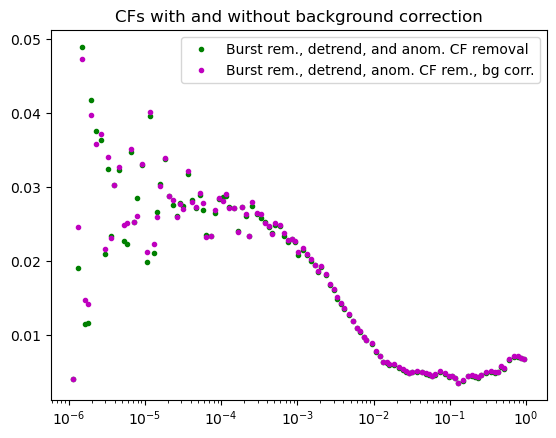

In [22]:
# Burst removal, detrend, and anomalous segment removal applied
default_uncertainty_method = 'Wohland'
minimum_window_length = []
n_bootstrap_reps = 10

lags_br_dt_ar_bg, cc_br_dt_ar_bg, sd_cc_br_dt_ar_bg, acr1_br_dt_ar_bg, acr2_br_dt_ar_bg = fixer.get_correlation_uncertainty(channels_spec_1,
                                                                                                                            channels_spec_2, 
                                                                                                                            default_uncertainty_method = default_uncertainty_method,
                                                                                                                            minimum_window_length = minimum_window_length,
                                                                                                                            n_bootstrap_reps = n_bootstrap_reps,
                                                                                                                            tau_min = None,
                                                                                                                            tau_max = None,
                                                                                                                            use_ext_weights = False, 
                                                                                                                            use_drift_correction = True,
                                                                                                                            use_flcs_bg_corr = True,
                                                                                                                            use_burst_removal = True,
                                                                                                                            use_mse_filter = True,
                                                                                                                            suppress_logging = False,
                                                                                                                            calling_function = script_name)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.semilogx(lags_br_dt_ar*1E-9, cc_br_dt_ar, '.g', label = 'Burst rem., detrend, and anom. CF removal')
ax.semilogx(lags_br_dt_ar_bg*1E-9, cc_br_dt_ar_bg, '.m', label = 'Burst rem., detrend, anom. CF rem., bg corr.')
ax.set_title('CFs with and without background correction')
ax.legend()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig.show()
